In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler

##############################################
# 1) Carga y Preprocesamiento de Datos
##############################################

import pandas as pd

# Cargar los datos
df = pd.read_csv('sales_data (1).csv', parse_dates=['Date'])
df = df[df['Weekly_Sales'] > 0]

# Ordenar por tienda, depto y fecha
df.sort_values(by=['Store', 'Dept', 'Date'], inplace=True)


df.fillna(method='ffill', inplace=True)




# Crear variables temporales
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
df['DayOfYear'] = df['Date'].dt.dayofyear

# Convertir IsHoliday a entero (0/1)
df["IsHoliday"] = df["IsHoliday"].astype(int)

# Codificar variables categóricas
store_encoder = LabelEncoder()
dept_encoder = LabelEncoder()


df['Store_id'] = store_encoder.fit_transform(df['Store'])
df['Dept_id'] = dept_encoder.fit_transform(df['Dept'])


# Variables numéricas para escalado y entrada
# Aquí se escalan algunas variables; se deja IsHoliday sin escalar
num_cols = [
    'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
    'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
    'Year', 'Month', 'Week', 'DayOfYear'
]
all_num_cols = num_cols + ['IsHoliday']

# Escalado de las variables (excepto IsHoliday)
max_dia = df['Date'].max()
test_start_date = max_dia - pd.Timedelta(weeks=15)

train_df = df[df['Date'] < test_start_date]
test_df = df[df['Date'] >= test_start_date]


scaler = MinMaxScaler()
train_df[num_cols]= scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])


C:\Users\57323\AppData\Local\Temp\ipykernel_2636\3099418455.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\57323\AppData\Local\Temp\ipykernel_2636\3099418455.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[num_cols]= scaler.fit_transform(train_df[num_cols])
C:\Users\57323\AppData\Local\Temp\ipykernel_2636\3099418455.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [2]:
train_df.to_csv('train_iniciales.csv', index=False)
test_df.to_csv('test_iniciales.csv', index=False)



In [3]:
# Para el DataFrame de entrenamiento
train_min_date = train_df['Date'].min()
train_max_date = train_df['Date'].max()

# Para el DataFrame de prueba
test_min_date = test_df['Date'].min()
test_max_date = test_df['Date'].max()

print("Fechas mínimas y máximas en train_df:")
print(f"Mínima: {train_min_date}, Máxima: {train_max_date}")



Fechas mínimas y máximas en train_df:
Mínima: 2010-02-05 00:00:00, Máxima: 2012-07-06 00:00:00


In [4]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, group_cols, cat_cols, num_cols, target_col,
                 seq_length=8, forecast_horizon=4):
        """
        df: DataFrame con todos los datos.
        group_cols: columnas para agrupar las series (usar 'Store_id' y 'Dept_id')
        cat_cols: variables categóricas (ej. ['Store_id', 'Dept_id', 'Type_id'])
        num_cols: variables numéricas (ej. all_num_cols)
        target_col: variable objetivo ('Weekly_Sales')
        seq_length: longitud de la secuencia de entrada.
        forecast_horizon: pasos a predecir (1 en este ejemplo).
        """
        self.df = df.copy()
        self.group_cols = group_cols
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.target_col = target_col
        self.seq_length = seq_length
        self.forecast_horizon = forecast_horizon

        self.X_cat, self.X_num, self.y = self._create_sequences()

    def _create_sequences(self):
        X_cat_list, X_num_list, y_list = [], [], []
        # Agrupar por tienda y depto (cada serie es una combinación única)
        grouped = self.df.groupby(self.group_cols, sort=False)
        for _, group in grouped:
            group_sorted = group.sort_values(by='Date')
            cat_data = group_sorted[self.cat_cols].values
            num_data = group_sorted[self.num_cols].values
            target = group_sorted[self.target_col].values
            # Solo se generan secuencias si la serie es lo suficientemente larga
            for i in range(len(group_sorted) - self.seq_length - self.forecast_horizon + 1):
                X_cat_seq = cat_data[i : i+self.seq_length]
                X_num_seq = num_data[i : i+self.seq_length]
                y_val = target[i + self.seq_length + self.forecast_horizon - 1]
                X_cat_list.append(X_cat_seq)
                X_num_list.append(X_num_seq)
                y_list.append(y_val)
        return (
            np.array(X_cat_list, dtype=np.float32),
            np.array(X_num_list, dtype=np.float32),
            np.array(y_list, dtype=np.float32)
        )

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_num[idx], self.y[idx]

# Parámetros del dataset
seq_length = 8
forecast_horizon = 4
target_col = 'Weekly_Sales'
cat_cols = ['Store_id', 'Dept_id']

# Se crean datasets de train y test
train_dataset = TimeSeriesDataset(train_df,
                                  group_cols=['Store_id', 'Dept_id'],
                                  cat_cols=cat_cols,
                                  num_cols=all_num_cols,
                                  target_col=target_col,
                                  seq_length=seq_length,
                                  forecast_horizon=forecast_horizon)

test_dataset = TimeSeriesDataset(test_df,
                                 group_cols=['Store_id', 'Dept_id'],
                                 cat_cols=cat_cols,
                                 num_cols=all_num_cols,
                                 target_col=target_col,
                                 seq_length=seq_length,
                                 forecast_horizon=forecast_horizon)

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##############################################
# 5) Modelo GlobalLSTM
##############################################

class GlobalLSTM(nn.Module):
    def __init__(self,
                 num_stores,   # total de tiendas
                 num_depts,    # total de deptos
                 emb_dim_store=4,
                 emb_dim_dept=8,
                 num_numeric_features=15,  # len(all_num_cols)
                 hidden_size=64,
                 num_layers=1,
                 dropout=0.2):
        super().__init__()

        # Embeddings para las variables categóricas
        self.store_emb = nn.Embedding(num_stores, emb_dim_store)
        self.dept_emb = nn.Embedding(num_depts, emb_dim_dept)


        # Dimensión total de entrada al LSTM
        self.input_dim = emb_dim_store + emb_dim_dept +  num_numeric_features

        self.lstm = nn.LSTM(input_size=self.input_dim,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, X_cat, X_num):
        """
        X_cat: tensor de tamaño [batch, seq_length, 3] con [Store_id, Dept_id, Type_id]
        X_num: tensor de tamaño [batch, seq_length, num_numeric_features]
        """
        store_id = X_cat[:, :, 0].long()
        dept_id = X_cat[:, :, 1].long()


        store_emb_out = self.store_emb(store_id)
        dept_emb_out = self.dept_emb(dept_id)


        # Concatenar embeddings y variables numéricas
        concat_input = torch.cat([store_emb_out, dept_emb_out,  X_num], dim=-1)
        lstm_out, _ = self.lstm(concat_input)
        last_out = lstm_out[:, -1, :]  # Tomamos el último paso de la secuencia
        out = self.fc(last_out)
        return out.squeeze(-1)

# Parámetros del modelo
num_stores = df['Store_id'].nunique()    # 45 tiendas
num_depts = df['Dept_id'].nunique()        # 99 deptos (según tus datos)


model = GlobalLSTM(
    num_stores=num_stores,
    num_depts=num_depts,
    emb_dim_store=4,
    emb_dim_dept=8,
    num_numeric_features=len(all_num_cols),
    hidden_size=64,
    num_layers=1,
    dropout=0.2
)

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

##############################################
# 6) Entrenamiento y Evaluación (Error Promedio Global)
##############################################

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

n_epochs = 50
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for X_cat_batch, X_num_batch, y_batch in train_loader:
        X_cat_batch = X_cat_batch.to(device)
        X_num_batch = X_num_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        preds = model(X_cat_batch, X_num_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_cat_batch.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{n_epochs}] - Loss: {avg_loss:.4f}")

# Evaluación en test (error promedio sobre todas las series)
model.eval()
test_losses = []
with torch.no_grad():
    for X_cat_batch, X_num_batch, y_batch in test_loader:
        X_cat_batch = X_cat_batch.to(device)
        X_num_batch = X_num_batch.to(device)
        y_batch = y_batch.to(device)
        preds = model(X_cat_batch, X_num_batch)
        loss = criterion(preds, y_batch)
        test_losses.append(loss.item() * X_cat_batch.size(0))
test_loss = np.sum(test_losses) / len(test_loader.dataset)
print(f"Test Loss (MSE Promedio Global): {test_loss:.4f}")


c:\Users\57323\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch [1/50] - Loss: 739544788.5245
Epoch [2/50] - Loss: 651461706.6165
Epoch [3/50] - Loss: 577237101.1998
Epoch [4/50] - Loss: 512302341.4882
Epoch [5/50] - Loss: 457418539.9404
Epoch [6/50] - Loss: 410071272.8611
Epoch [7/50] - Loss: 368823354.6010
Epoch [8/50] - Loss: 332813668.4794
Epoch [9/50] - Loss: 300945491.6698
Epoch [10/50] - Loss: 273124096.2152
Epoch [11/50] - Loss: 249135361.8037
Epoch [12/50] - Loss: 227887296.4357
Epoch [13/50] - Loss: 209982472.0019
Epoch [14/50] - Loss: 193175163.7173
Epoch [15/50] - Loss: 179190357.1272
Epoch [16/50] - Loss: 166456633.0312
Epoch [17/50] - Loss: 155681915.8964
Epoch [18/50] - Loss: 146460762.7467
Epoch [19/50] - Loss: 138721415.2165
Epoch [20/50] - Loss: 131085649.9582
Epoch [21/50] - Loss: 125539713.1241
Epoch [22/50] - Loss: 121054860.2501
Epoch [23/50] - Loss: 116978578.4069
Epoch [24/50] - Loss: 111889511.0280
Epoch [25/50] - Loss: 108069955.4600
Epoch [26/50] - Loss: 105444307.3855
Epoch [27/50] - Loss: 104387229.6447
Epoch [28/

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_model_on_test(model, test_df, cat_cols, num_cols, seq_length=8, device='cpu'):
    """
    Evalúa el modelo en el conjunto de prueba, prediciendo semana a semana.
    Retorna un DataFrame con predicciones y calcula el error.
    """
    test_predictions = []
    stores = test_df['Store_id'].unique()

    for store_id in stores:
        depts = test_df[test_df['Store_id'] == store_id]['Dept_id'].unique()

        for dept in depts:
            sub_df = test_df[(test_df['Store_id'] == store_id) & (test_df['Dept_id'] == dept)].sort_values('Date')

            if len(sub_df) < seq_length:
                continue  # Saltar si no hay suficientes datos

            for i in range(len(sub_df) - seq_length):
                # Obtener la secuencia de entrada
                last_seq = sub_df.iloc[i:i + seq_length]
                X_cat = last_seq[cat_cols].values[np.newaxis, :, :]
                X_num = last_seq[num_cols].values[np.newaxis, :, :]

                # Convertir a tensores
                X_cat_t = torch.tensor(X_cat, dtype=torch.float32).to(device)
                X_num_t = torch.tensor(X_num, dtype=torch.float32).to(device)

                print("X_cat_t shape:", X_cat_t.shape)
                print("X_num_t shape:", X_num_t.shape)

                # Obtener predicción
                model.eval()
                with torch.no_grad():
                    pred = model(X_cat_t, X_num_t).item()

                # Registrar predicción con fecha real de la semana
                true_value = sub_df.iloc[i + seq_length]['Weekly_Sales']
                date_value = sub_df.iloc[i + seq_length]['Date']

                test_predictions.append({
                    'Store_id': store_id,
                    'Dept_id': dept,
                    'Date': date_value,
                    'Predicted_Weekly_Sales': pred,
                    'Actual_Weekly_Sales': true_value
                })

    pred_df = pd.DataFrame(test_predictions)

    # Calcular métricas de error
    mae = mean_absolute_error(pred_df['Actual_Weekly_Sales'], pred_df['Predicted_Weekly_Sales'])
    mse = mean_squared_error(pred_df['Actual_Weekly_Sales'], pred_df['Predicted_Weekly_Sales'])

    print(f"Evaluación del modelo en test:\nMAE: {mae:.2f}\nMSE: {mse:.2f}")

    return pred_df

# Evaluar el modelo en el conjunto de prueba
test_pred_df = evaluate_model_on_test(model, test_df, cat_cols, all_num_cols, seq_length=8, device=device)

# Mostrar las primeras predicciones
test_pred_df



X_cat_t shape: torch.Size([1, 8, 2])
X_num_t shape: torch.Size([1, 8, 15])
X_cat_t shape: torch.Size([1, 8, 2])
X_num_t shape: torch.Size([1, 8, 15])
X_cat_t shape: torch.Size([1, 8, 2])
X_num_t shape: torch.Size([1, 8, 15])
X_cat_t shape: torch.Size([1, 8, 2])
X_num_t shape: torch.Size([1, 8, 15])
X_cat_t shape: torch.Size([1, 8, 2])
X_num_t shape: torch.Size([1, 8, 15])
X_cat_t shape: torch.Size([1, 8, 2])
X_num_t shape: torch.Size([1, 8, 15])
X_cat_t shape: torch.Size([1, 8, 2])
X_num_t shape: torch.Size([1, 8, 15])
X_cat_t shape: torch.Size([1, 8, 2])
X_num_t shape: torch.Size([1, 8, 15])
X_cat_t shape: torch.Size([1, 8, 2])
X_num_t shape: torch.Size([1, 8, 15])
X_cat_t shape: torch.Size([1, 8, 2])
X_num_t shape: torch.Size([1, 8, 15])
X_cat_t shape: torch.Size([1, 8, 2])
X_num_t shape: torch.Size([1, 8, 15])
X_cat_t shape: torch.Size([1, 8, 2])
X_num_t shape: torch.Size([1, 8, 15])
X_cat_t shape: torch.Size([1, 8, 2])
X_num_t shape: torch.Size([1, 8, 15])
X_cat_t shape: torch.Size

,Store_id,Dept_id,Date,Predicted_Weekly_Sales,Actual_Weekly_Sales
0,0,0,2012-09-07,23825.916016,18322.37
1,0,0,2012-09-14,26054.062500,19616.22
2,0,0,2012-09-21,24366.998047,19251.50
3,0,0,2012-09-28,23148.177734,18947.81
4,0,0,2012-10-05,24363.519531,21904.47
...,...,...,...,...,...
23052,44,79,2012-09-28,3174.815674,508.37
23053,44,79,2012-10-05,3151.842285,628.10
23054,44,79,2012-10-12,3051.560303,1061.02
23055,44,79,2012-10-19,3156.192627,760.01


In [7]:
from sklearn.metrics import mean_absolute_percentage_error


mape = mean_absolute_percentage_error(test_pred_df["Actual_Weekly_Sales"] , test_pred_df['Predicted_Weekly_Sales'] )
print(f"MAPE: {mape:.4f}")

MAPE: 53.7072


In [8]:
import numpy as np
import torch
import pandas as pd

def predict_future_weeks(model, df, store_id, dept_id=None, cat_cols=[], num_cols=[], seq_length=8, forecast_horizon=4, device='cpu'):
    """
    Predice las ventas de las próximas 'forecast_horizon' semanas para una tienda y departamento específico.
    Si dept_id es None, predice para todos los departamentos de la tienda.
    
    Parámetros:
    - model: Modelo LSTM entrenado
    - df: DataFrame con los datos históricos
    - store_id: ID de la tienda
    - dept_id: ID del departamento (opcional). Si None, predice para todos los deptos.
    - cat_cols: Columnas categóricas
    - num_cols: Columnas numéricas
    - seq_length: Longitud de la secuencia usada para predicción
    - forecast_horizon: Número de semanas a predecir
    - device: CPU o GPU
    
    Retorna:
    - DataFrame con predicciones
    """
    preds = []
    depts = [dept_id] if dept_id is not None else df[df['Store_id'] == store_id]['Dept_id'].unique()
    
    for dept in depts:
        sub_df = df[(df['Store_id'] == store_id) & (df['Dept_id'] == dept)].sort_values('Date')
        if len(sub_df) < seq_length:
            print(f"⚠️ No hay suficientes datos para la tienda {store_id}, depto {dept}.")
            continue
        
        last_seq = sub_df.iloc[-seq_length:].copy()
        X_cat = last_seq[cat_cols].values[np.newaxis, :, :]
        X_num = last_seq[num_cols].values[np.newaxis, :, :]

        X_cat_t = torch.tensor(X_cat, dtype=torch.float32).to(device)
        X_num_t = torch.tensor(X_num, dtype=torch.float32).to(device)


        model.eval()
        with torch.no_grad():
            for week_ahead in range(forecast_horizon):
                pred = model(X_cat_t, X_num_t).cpu().item()
                
                preds.append({
                    'Store_id': store_id,
                    'Dept_id': dept,
                    'Week_Ahead': week_ahead + 1,
                    'Predicted_Weekly_Sales': pred
                })
                
                # Actualizar la secuencia para la siguiente predicción
                new_row = np.hstack([
                    X_cat_t.cpu().numpy()[0, -1, :],  # Última fila de categorías
                    np.append(X_num_t.cpu().numpy()[0, -1, 1:], pred)  # Desplaza y añade predicción
                ])
                
                X_cat_t = torch.tensor(np.vstack([X_cat_t.cpu().numpy()[0, 1:, :], new_row[:len(cat_cols)]]), dtype=torch.float32).unsqueeze(0).to(device)
                X_num_t = torch.tensor(np.vstack([X_num_t.cpu().numpy()[0, 1:, :], new_row[len(cat_cols):]]), dtype=torch.float32).unsqueeze(0).to(device)

    return pd.DataFrame(preds)

# 🔹 Ejemplo de uso con tienda y departamento específicos
store_id_example = 1
dept_id_example = 0  # Cambia a None para predecir todos los deptos de la tienda
forecast_horizon = 4

future_pred_df = predict_future_weeks(model, df, store_id_example, dept_id_example, cat_cols, all_num_cols, seq_length=8, forecast_horizon=forecast_horizon, device=device)

print(future_pred_df)


   Store_id  Dept_id  Week_Ahead  Predicted_Weekly_Sales
0         1        0           1            27193.019531
1         1        0           2            19595.775391
2         1        0           3            17414.619141
3         1        0           4            13882.251953


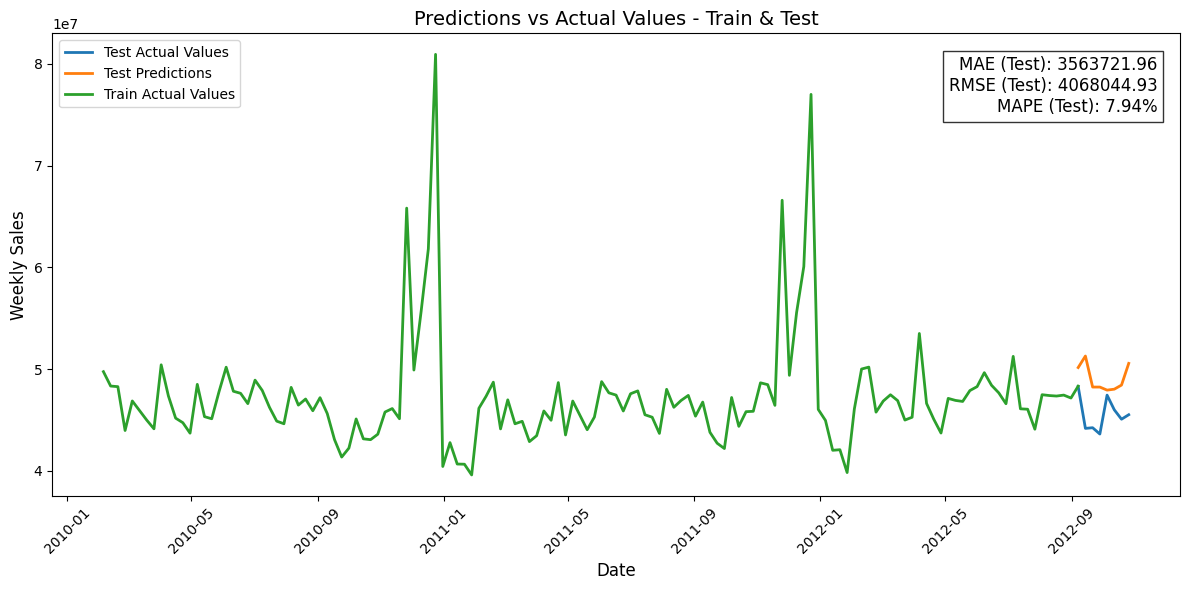

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error

# Cargar los datos
df = pd.read_csv('sales_data (1).csv', parse_dates=['Date'])
df_dates_sorted = df.sort_values('Date')
max_date = df_dates_sorted['Date'].max()
test_start_date = max_date - pd.Timedelta(weeks=12)

train_df = df[df['Date'] <= "2012-09-07"]
test_df = df[df['Date'] >= test_start_date]

# Asegurar que la fecha es tipo datetime
test_pred_df['Date'] = pd.to_datetime(test_pred_df['Date'])

# Agrupar por fecha y sumar las ventas reales de los datos de test
df_test_grouped = test_pred_df.groupby('Date').agg({
    'Actual_Weekly_Sales': 'sum',
    'Predicted_Weekly_Sales': 'sum'
}).reset_index()

# Agrupar por fecha las ventas reales de los datos de train
df_train_grouped = train_df.groupby('Date').agg({
    'Weekly_Sales': 'sum'
}).reset_index()

# Asegurarse de que todas las fechas estén en el mismo DataFrame (unir entrenamiento y prueba)
combined_df = pd.concat([df_train_grouped[['Date', 'Weekly_Sales']], df_test_grouped[['Date', 'Actual_Weekly_Sales', 'Predicted_Weekly_Sales']]], ignore_index=True)

# Ordenar las fechas
combined_df = combined_df.sort_values('Date')

# Crear la figura
plt.figure(figsize=(12, 6))

# Estilo unificado para todas las líneas
line_style = '-'
marker_style = None  # Eliminar los marcadores para hacer las líneas más uniformes
line_width = 2

# Graficar valores reales de test
plt.plot(df_test_grouped['Date'], df_test_grouped['Actual_Weekly_Sales'], linestyle=line_style, label="Test Actual Values", color='#1f77b4', linewidth=line_width)

# Graficar valores predichos de test
plt.plot(df_test_grouped['Date'], df_test_grouped['Predicted_Weekly_Sales'], linestyle=line_style, label="Test Predictions", color='#ff7f0e', linewidth=line_width)

# Graficar valores reales de train
plt.plot(df_train_grouped['Date'], df_train_grouped['Weekly_Sales'], linestyle=line_style, label="Train Actual Values", color='#2ca02c', linewidth=line_width)

# Agregar etiquetas y título
plt.xlabel("Date", fontsize=12)
plt.ylabel("Weekly Sales", fontsize=12)
plt.title(f"Predictions vs Actual Values - Train & Test", fontsize=14)

# Mostrar leyenda
plt.legend()

# Calcular métricas MAE, RMSE y MAPE para test
actual_values_test = df_test_grouped['Actual_Weekly_Sales'].values
predicted_values_test = df_test_grouped['Predicted_Weekly_Sales'].values

mae_test = abs(actual_values_test - predicted_values_test).mean()
rmse_test = ((actual_values_test - predicted_values_test) ** 2).mean() ** 0.5
mape_test = mean_absolute_percentage_error(actual_values_test, predicted_values_test) * 100  # Convertir a porcentaje

# Mostrar métricas en un cuadro de texto en un lugar adecuado
textstr = f'MAE (Test): {mae_test:.2f}\nRMSE (Test): {rmse_test:.2f}\nMAPE (Test): {mape_test:.2f}%'
plt.gca().text(0.98, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
              verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))

# Rotar las fechas para mejor visualización
plt.xticks(rotation=45)

# Mejorar espacio en la gráfica
plt.tight_layout()

# Mostrar la gráfica
plt.show()



In [12]:
actual_values_test = df_test_grouped['Actual_Weekly_Sales'].values
predicted_values_test = df_test_grouped['Predicted_Weekly_Sales'].values
actual_values_test




array([48288188.28, 44176109.3 , 44242279.95, 43621013.22, 47443654.33,
       46003421.11, 45078363.97, 45518534.92])

In [13]:
predicted_values_test

array([50154826.50061035, 51287378.03179932, 48238024.38183594,
       48237531.7947998 , 47937025.25543213, 48029785.26806641,
       48432504.40722656, 50564265.1472168 ])

In [14]:
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error

# Agrupar por Store y Dept y calcular el MAPE
mape_by_store_dept = (
    test_pred_df.groupby(['Store_id', 'Dept_id'])
    .apply(lambda x: mean_absolute_percentage_error(x["Actual_Weekly_Sales"], x["Predicted_Weekly_Sales"]))
    .reset_index(name='MAPE')
)

# Ordenar por el menor MAPE
best_mape = mape_by_store_dept.sort_values('MAPE').head(80)  # Los 10 mejores
best_mape

C:\Users\57323\AppData\Local\Temp\ipykernel_2636\3025080633.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: mean_absolute_percentage_error(x["Actual_Weekly_Sales"], x["Predicted_Weekly_Sales"]))


,Store_id,Dept_id,MAPE
790,11,38,0.022735
263,3,66,0.024199
1489,21,38,0.025581
2115,30,71,0.029743
2843,43,3,0.030913
...,...,...,...
2137,31,12,0.064269
2589,38,72,0.064335
2560,38,32,0.064765
1002,14,38,0.064814


In [15]:
# Filtrar los MAPE mayores a 1
high_mape = mape_by_store_dept[mape_by_store_dept["MAPE"] > 1]

# Mostrar los resultados
print("MAPEs mayores a 1:")
print(high_mape)

MAPEs mayores a 1:
      Store_id  Dept_id      MAPE
25           0       25  1.348252
26           0       26  1.931086
27           0       27  1.102872
29           0       29  1.187355
34           0       34  6.159927
...        ...      ...       ...
2940        44       56  6.500479
2942        44       59  1.043210
2946        44       65  4.571811
2955        44       74  2.849095
2959        44       79  4.131049

[783 rows x 3 columns]


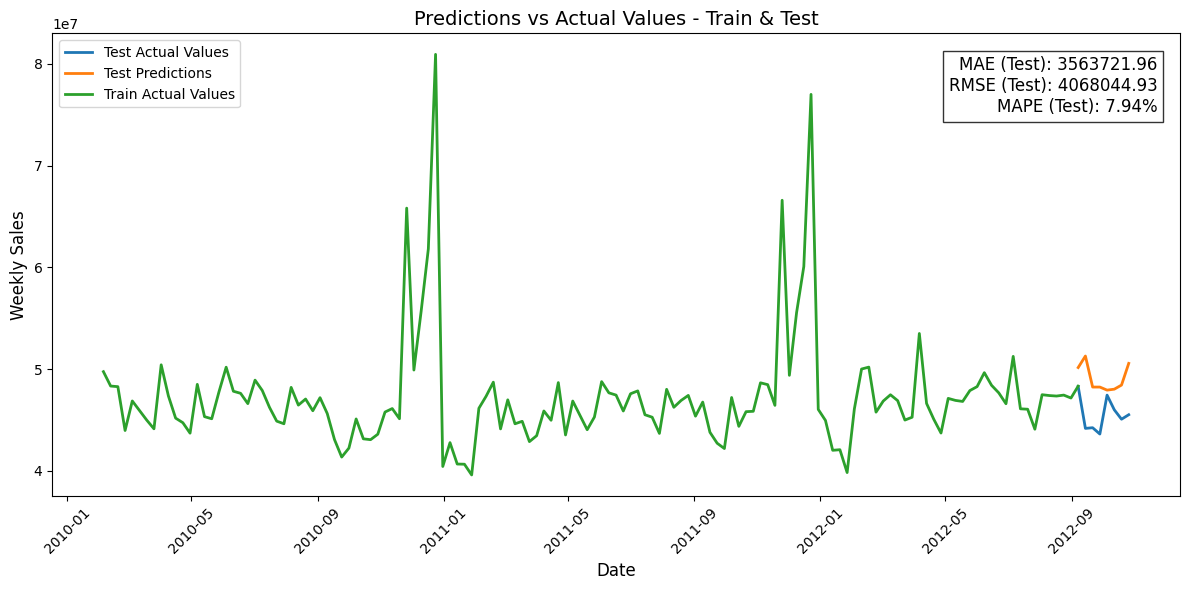

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error

def plot_sales_data(df, test_pred_df, show_by_dept_and_store=False):
    # Cargar y preprocesar los datos
    df_dates_sorted = df.sort_values('Date')
    max_date = df_dates_sorted['Date'].max()
    test_start_date = max_date - pd.Timedelta(weeks=12)

    train_df = df[df['Date'] <= "2012-09-07"]
    test_df = df[df['Date'] >= test_start_date]

    # Asegurar que la fecha es tipo datetime
    test_pred_df['Date'] = pd.to_datetime(test_pred_df['Date'])

    # Agrupar por fecha y sumar las ventas reales de los datos de test
    df_test_grouped = test_pred_df.groupby('Date').agg({
        'Actual_Weekly_Sales': 'sum',
        'Predicted_Weekly_Sales': 'sum'
    }).reset_index()

    # Agrupar por fecha las ventas reales de los datos de train
    df_train_grouped = train_df.groupby('Date').agg({
        'Weekly_Sales': 'sum'
    }).reset_index()

    # Asegurarse de que todas las fechas estén en el mismo DataFrame (unir entrenamiento y prueba)
    combined_df = pd.concat([df_train_grouped[['Date', 'Weekly_Sales']], df_test_grouped[['Date', 'Actual_Weekly_Sales', 'Predicted_Weekly_Sales']]], ignore_index=True)

    # Ordenar las fechas
    combined_df = combined_df.sort_values('Date')

    # Crear la figura
    plt.figure(figsize=(12, 6))

    # Estilo unificado para todas las líneas
    line_style = '-'
    marker_style = None  # Eliminar los marcadores para hacer las líneas más uniformes
    line_width = 2

    if show_by_dept_and_store:
        # Graficar por Dept_id y Store_id (segmentado)
        for dept in df['Dept'].unique():
            for store in df['Store'].unique():
                df_filtered = df[(df['Dept'] == dept) & (df['Store'] == store)]
                df_filtered_grouped = df_filtered.groupby('Date').agg({
                    'Weekly_Sales': 'sum'
                }).reset_index()
                
                plt.plot(df_filtered_grouped['Date'], df_filtered_grouped['Weekly_Sales'], linestyle=line_style, label=f"Dept {dept} Store {store}", linewidth=line_width)
    else:
        # Graficar valores generales de test
        plt.plot(df_test_grouped['Date'], df_test_grouped['Actual_Weekly_Sales'], linestyle=line_style, label="Test Actual Values", color='#1f77b4', linewidth=line_width)

        # Graficar valores predichos de test
        plt.plot(df_test_grouped['Date'], df_test_grouped['Predicted_Weekly_Sales'], linestyle=line_style, label="Test Predictions", color='#ff7f0e', linewidth=line_width)

        # Graficar valores reales de train
        plt.plot(df_train_grouped['Date'], df_train_grouped['Weekly_Sales'], linestyle=line_style, label="Train Actual Values", color='#2ca02c', linewidth=line_width)

    # Agregar etiquetas y título
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Weekly Sales", fontsize=12)
    plt.title(f"Predictions vs Actual Values - {'Train & Test' if not show_by_dept_and_store else 'By Dept & Store'}", fontsize=14)

    # Mostrar leyenda
    plt.legend()

    # Calcular métricas MAE, RMSE y MAPE para test
    if not show_by_dept_and_store:
        actual_values_test = df_test_grouped['Actual_Weekly_Sales'].values
        predicted_values_test = df_test_grouped['Predicted_Weekly_Sales'].values

        mae_test = abs(actual_values_test - predicted_values_test).mean()
        rmse_test = ((actual_values_test - predicted_values_test) ** 2).mean() ** 0.5
        mape_test = mean_absolute_percentage_error(actual_values_test, predicted_values_test) * 100  # Convertir a porcentaje

        # Mostrar métricas en un cuadro de texto
        textstr = f'MAE (Test): {mae_test:.2f}\nRMSE (Test): {rmse_test:.2f}\nMAPE (Test): {mape_test:.2f}%'
        plt.gca().text(0.98, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
                      verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))

    # Rotar las fechas para mejor visualización
    plt.xticks(rotation=45)

    # Mejorar espacio en la gráfica
    plt.tight_layout()

    # Mostrar la gráfica
    plt.show()

# Uso de la función: 
# Para ver la gráfica general
plot_sales_data(df, test_pred_df)




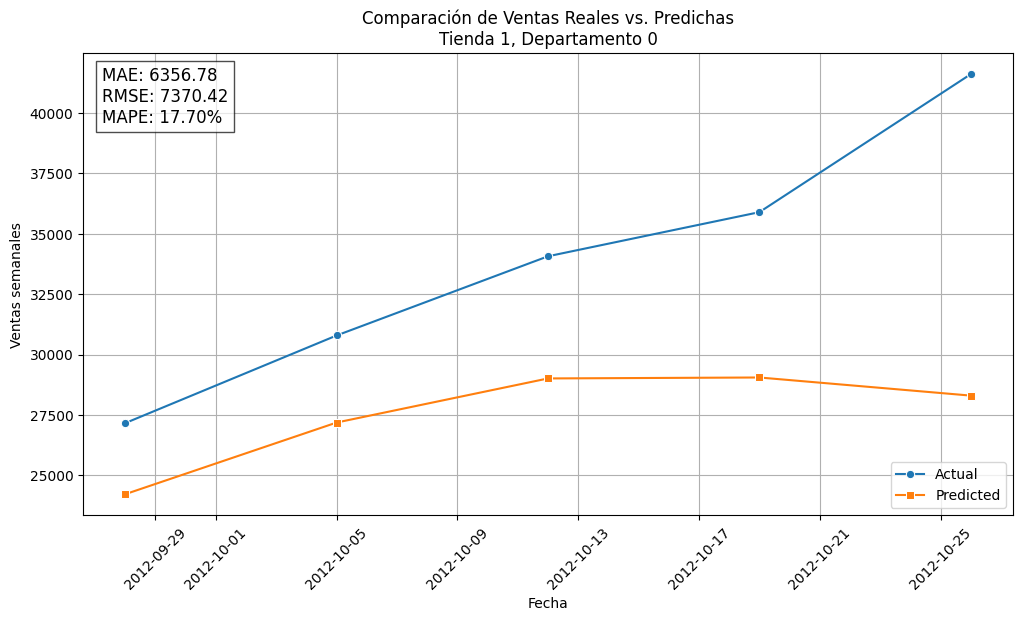

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

def plot_predictions_with_metrics(pred_df, store_id, dept_id):
    """
    Grafica las ventas reales vs. predichas en el tiempo para una tienda y departamento específicos.
    Calcula y muestra las métricas MAE, RMSE y MAPE dentro del gráfico.
    """
    # Filtrar datos
    df_filtered = pred_df[(pred_df['Store_id'] == store_id) & (pred_df['Dept_id'] == dept_id)]

    if df_filtered.empty:
        print(f"No hay datos para la Tienda {store_id}, Departamento {dept_id}")
        return

    # Ordenar por fecha
    df_filtered = df_filtered.sort_values('Date')

    # Extraer valores reales y predichos
    actual_values = df_filtered['Actual_Weekly_Sales'].values
    predicted_values = df_filtered['Predicted_Weekly_Sales'].values

    # Calcular métricas
    mae = np.abs(actual_values - predicted_values).mean()
    rmse = np.sqrt(((actual_values - predicted_values) ** 2).mean())
    mape = mean_absolute_percentage_error(actual_values, predicted_values) * 100  # Convertir a porcentaje

    # Configurar el gráfico
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_filtered, x='Date', y='Actual_Weekly_Sales', label='Actual', marker='o')
    sns.lineplot(data=df_filtered, x='Date', y='Predicted_Weekly_Sales', label='Predicted', marker='s')

    # Añadir métricas en el gráfico
    metric_text = f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nMAPE: {mape:.2f}%"
    plt.text(0.02, 0.85, metric_text, transform=plt.gca().transAxes, fontsize=12,
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

    # Mejorar formato
    plt.xlabel("Fecha")
    plt.ylabel("Ventas semanales")
    plt.title(f"Comparación de Ventas Reales vs. Predichas\nTienda {store_id}, Departamento {dept_id}")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

# Llamar la función para una tienda y departamento específicos

plot_predictions_with_metrics(test_pred_df, store_id=1, dept_id=0)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error

# Asegurar que la fecha es tipo datetime
test_pred_df['Date'] = pd.to_datetime(test_pred_df['Date'])

# Obtener todas las combinaciones únicas de Store_id y Dept_id
store_dept_combinations = test_pred_df[['Store_id', 'Dept_id']].drop_duplicates()

for _, row in store_dept_combinations.iterrows():
    store_id, dept_id = row['Store_id'], row['Dept_id']
    
    # Filtrar los datos por la tienda y el departamento
    df_filtered = test_pred_df[(test_pred_df['Store_id'] == store_id) & (test_pred_df['Dept_id'] == dept_id)]
    
    # Verificar si hay datos disponibles
    if df_filtered.empty:
        print(f"No hay datos disponibles para Store {store_id} y Dept {dept_id}.")
        continue
    
    # Crear la figura
    plt.figure(figsize=(12, 6))
    
    # Graficar valores reales
    plt.plot(df_filtered['Date'], df_filtered['Actual_Weekly_Sales'], marker='o', linestyle='-', label="Actual Values", color='blue')
    
    # Graficar valores predichos
    plt.plot(df_filtered['Date'], df_filtered['Predicted_Weekly_Sales'], marker='s', linestyle='-', label="Predictions", color='orange')
    
    # Agregar etiquetas y título
    plt.xlabel("Date")
    plt.ylabel("Weekly Sales")
    plt.title(f"Predictions vs Actual Values - Store {store_id}, Dept {dept_id}")
    
    # Mostrar leyenda
    plt.legend()
    
    # Calcular métricas MAE, RMSE y MAPE
    actual_values = df_filtered['Actual_Weekly_Sales'].values
    predicted_values = df_filtered['Predicted_Weekly_Sales'].values
    
    mae = abs(actual_values - predicted_values).mean()
    rmse = ((actual_values - predicted_values) ** 2).mean() ** 0.5
    mape = mean_absolute_percentage_error(actual_values, predicted_values) * 100
    
    # Mostrar métricas en un cuadro de texto
    textstr = f'MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nMAPE: {mape:.2f}%'
    plt.text(df_filtered['Date'].iloc[0], max(actual_values), textstr, bbox=dict(facecolor='white', alpha=0.8))
    
    # Rotar las fechas para mejor visualización
    plt.xticks(rotation=45)
    
    # Mostrar la gráfica
    plt.show()

In [157]:
torch.save(model.state_dict(), 'modelo_demanda.pth')
